In [1]:
# Install a pip package in the current Jupyter kernel

import dlib, cv2, os
from imutils import face_utils
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image

2021-11-14 17:01:14.634905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-14 17:01:14.634928: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
detector = dlib.cnn_face_detection_model_v1('/home/data/data/kodeiri/ML_project/dogHeadDetector.dat')
predictor = dlib.shape_predictor('/home/data/data/kodeiri/ML_project/landmarkDetector.dat')

In [3]:
path='/home/data/data/kodeiri/ML_project/Test_aug_bufer/Adult/_5_6861445.png'

In [4]:
# wyszukiwanie zdjęcia na białym tle
def photo_detector(src_image):

    img_in = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, dsize=None, fx=0.5, fy=0.5)
    
    gray = cv2.cvtColor(img_in, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape

    ret, thresh = cv2.threshold(gray, 254, 255, 1)

    # f, axarr = plt.subplots(1,3)

    photo_width = np.count_nonzero(thresh == 255, axis=0).max()
    photo_height = np.count_nonzero(thresh == 0, axis=1).min()

    column, row, photo_width, photo_height = cv2.boundingRect(thresh)

    # axarr[0].imshow(thresh)
    # axarr[1].imshow(thresh[row:row+photo_height, column:column+photo_width])
    # axarr[2].imshow(img_in[row:row+photo_height, column:column+photo_width])
    # print((column, row, photo_width, photo_height))
    return (column, row, photo_width, photo_height)

# wycinanie zdjęcia z biełego tła oraz reskalowanie do 100x100
def image_crop(src_image, cordinates, res=(100, 100)):

    column, row, photo_width, photo_height = cordinates
    result_image = src_image[row:row + photo_height, column: column + photo_width]
    return cv2.resize(result_image, res)
    # return img_in[]
    # for rows in thresh:
    
    # img2, contours, hierarchy = cv2.findContours(thresh, 1, 2)
    # plt.imshow(img2)
    
    # print(np.where(thresh == 255) )
 
    # mask = 255 - mask

    # mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

    # cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    # cnt = sorted(cnts, key=cv2.contourArea)[-1]

    # x,y,w,h = cv2.boundingRect(cnt)
    # print(x, y, w, h)
    # dst = img_in[y:y+h, x:x+w]

    # result = img_in.copy()
    # result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
    # result[:, :, 3] = mask
    # img_in[:,:,3] = mask
    # plt.imshow(img_in)

    # dets = detector(img_in, upsample_num_times=1)

    # #print(dets)

    # img_result = img_in.copy()

    # for i, d in enumerate(dets):
    #     print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} Confidence: {}".format(i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))

    #     ((x1, y1), (x2, y2)) = (d.rect.left(), d.rect.top()), (d.rect.right(), d.rect.bottom())
    #     if y1 < 0:
    #         y1 = 0
    #     if x1 < 0:
    #         x1 = 0
    #     if x2 < 0:
    #         x2 = 0
    #     if y2 < 0:
    #         y2 = 0 


    # return ((x1, y1), (x2, y2))

# znajdywanie featerów na pieskach, tutaj każde zdjęcie zostaje podane operacji wyrównania histogramu, poczym cechy zostają wyciagnięte
def features_detector(src_image):

    ycrvb_img = cv2.cvtColor(src_image, cv2.COLOR_BGR2YCrCb)
    ycrvb_img[:, :, 0] = cv2.equalizeHist(ycrvb_img[:, :, 0])

    yuv_img = cv2.cvtColor(src_image, cv2.COLOR_BGR2YUV)
    yuv_img[:, :, 0] = cv2.equalizeHist(yuv_img[:, :, 0])

    equlized_img1 = cv2.cvtColor(ycrvb_img, cv2.COLOR_YCrCb2BGR)
    equlized_img2 = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2BGR)

    # f, axarr = plt.subplots(1,4)
    # axarr[0].imshow(image)
    # axarr[1].imshow(ycrvb_img)
    # axarr[2].imshow(equlized_img1)
    # axarr[3].imshow(equlized_img2)

    dets = detector(equlized_img1, upsample_num_times=1)
    # if len(dets):
    if len(dets):
        shape = predictor(equlized_img1, dets.pop().rect)
        (forehead, right_ear, right_eye, nose, left_ear, left_eye) = face_utils.shape_to_np(shape)

        return (forehead, right_ear, right_eye, nose, left_ear, left_eye)
    else:
        return []


In [5]:
# obraca zdjęcie tak, że linia oczu jest horyzontalnie
def img_rotate(src_image, face_features, res=(100, 100)):

    (forehead, right_ear, (x2, y2), nose, left_ear, (x1, y1)) = face_features
    
    slope = (y2 - y1) / (x2 - x1)
    rad = np.arctan2(y2 - y1, x2 - x1)
    angle = np.rad2deg(rad)

    cX = int(nose[0])
    cY = int(nose[1])
    rotationMatrix = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotatedImage = cv2.warpAffine(src_image, rotationMatrix, res)

    # plt.imshow(rotatedImage)

    return rotatedImage
    
def translate_image(src_image, translate_destination, feautres, feature_id=3, res=(100, 100)):
    tX, tY = translate_destination
    bX, bY = feautres[feature_id]

    M = np.float32([[1, 0, tX - bX],[0, 1,  tY - bY]])

    return_image = cv2.warpAffine(src_image, M, res)
    return return_image

def check_triangle_angles(face_features, max_angle = 70.0):
    (forehead, right_ear, (x1, y1), (x2, y2), left_ear, (x3, y3)) = face_features

    # calculate distance between dog eyes 
    a = np.sqrt((x1 - x3) ** 2 + (y1 - y3) ** 2)
    # calculate distance between dog left eye and nose 
    b = np.sqrt((x2 - x3) ** 2 + (y2 - y3) ** 2)
    # calculate distance between dog right eye and nose 
    c = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    
    cos_a = (b ** 2 + c ** 2 - a ** 2) / (2 * b * c)
    cos_b = (c ** 2 + a ** 2 - b ** 2) / (2 * a * c)
    cos_c = (a ** 2 + b ** 2 - c ** 2) / (2 * a * b)

    angle_a = np.rad2deg(np.arccos(cos_a))
    angle_b = np.rad2deg(np.arccos(cos_b))
    angle_c = np.rad2deg(np.arccos(cos_c))

    # print(angle_a, angle_b, angle_c)
    if angle_a < max_angle and angle_b < max_angle and angle_c < max_angle:
        return True

    return False
    

False

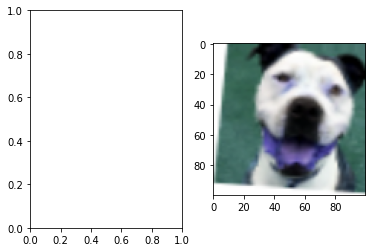

In [6]:
test_image = cv2.imread(path)

fig, ax = plt.subplots(1, 2)

photo_cordinates = photo_detector(test_image)
test_image = image_crop(test_image, photo_cordinates, (100, 100))
plt.imshow(test_image)
feautres = features_detector(test_image)
test_image = img_rotate(test_image, feautres)
feautres = features_detector(test_image)
test_image = translate_image(test_image, (50, 50), feautres)
feautres = features_detector(test_image)
check_triangle_angles(feautres, 70.0)




# plt.imshow(image)
# plt.show()

In [7]:
model3 = tf.keras.models.load_model("/home/data/data/kodeiri/ML_project/saved_model/my_model4")

2021-11-14 17:01:17.123931: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-14 17:01:17.124485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:c1:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6705GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-11-14 17:01:17.124591: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-14 17:01:17.124646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-14 17:01:17.124687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic l

In [8]:
CATEGORIES = ["Adult", "Senior", "Young"]

In [9]:
def predDecoder(prediction):
    x = np.argmax(prediction)
    # print("Prediction: " + CATEGORIES[x])
    prob = prediction[x]
    # print("Confidence: "+ str(prob))
    return (CATEGORIES[x])

In [10]:
def gradCAM(path,ground_truth, intensity=0.5, res=100):
  
  model=model3
  intensity=0.8
  res=100
  #iteration_number=len(os.listdir(path))
  iteration_number = 1000
  i=0
  cntr = 0
  piclist=os.listdir(path)
  hm_sum = np.zeros((100, 100, 3, 1))
  for i in range(iteration_number):
    # print(i)
    img_path=path+piclist[i]
    img = image.load_img(img_path, target_size=(100, 100))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x.astype(np.float32)
    x/=255
    preds = model.predict(x)[0]
    #predDecoder(preds)
    # print("Ground_truth: "+ ground_truth)
    if predDecoder(preds) == ground_truth:
      cntr=cntr+1
    # #x = preprocess_input(x)
    conv_layer = model.get_layer(index=0)
    heatmap_model = tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])
    
    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(x)
        argmax=tf.argmax(predictions[0])
        loss = predictions[:, argmax]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = K.mean(grads, axis=(0,1,2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    # heatmap = heatmap.squeeze()
    # heatmap = np.log10(heatmap / max_heat)
    img = cv2.imread(img_path)
    heatmap = heatmap.squeeze()
    
    heatmap = cv2.resize(heatmap, (res, res))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_HOT)
    # wycinanie zdjęcia, znajdowanie featuró i obracanie zdjęć tak akby linia oczu była prosta
    # photo_cordinates = photo_detector(img)
    # img = image_crop(img, photo_cordinates, res=(res, res))
    # heatmap = image_crop(heatmap, photo_cordinates, res=(res, res))
    features = features_detector(img)
    if len(features):
      img = img_rotate(img, features, res=(res, res))
      heatmap = img_rotate(heatmap, features, res=(res, res))

    # wykrywanie featerów oraz translacja zdjęcia, tak aby nos znadował się w pozycji 50x50
    features = features_detector(img)
    if len(features):
      img = translate_image(img, (50, 50), features, res=(res, res))
      heatmap = translate_image(heatmap, (50, 50), features, res=(res, res))

    # sprawdzenie czy znaki charakterystyczne pyska psa spełniają odpowiednie założenie - kąt maskymalny nie mozę przekraczać konkretnej wartosći
    features = features_detector(img)
    if len(features) and check_triangle_angles(features, max_angle = 70.0):
      # hm_sum[:, :, :, i] = heatmap
      hm_sum = np.append(hm_sum, heatmap.reshape((100, 100, 3, 1)), axis=3)
    # elif check_triangle_angles(feautres, max_angle=70.0):
      # hm_sum = hm_sum + heatmap

      # heatmap = translate_image(heatmap, (50, 50), features)
    # img = cv2.resize(img, (res, res))
    # heatmap = cv2.resize(heatmap,(res,res))
    # img = heatmap * intensity + img     ## nakładam HM na obrazek, biorę tylko piksele z kwadratu, który wykrył face detector
    # img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)
    # img = img/np.amax(img)
    # plt.imshow(img)
    # plt.show()
      
    # except:
    #   photo_cordinatesg = photo_detector(img)
    #   img = image_crop(img, photo_cordinates)
    #   img = cv2.resize(img, (res, res))
      # img = heatmap * intensity + img

      # print ("Cannot detect dog face. Skipping image display. ")
    # print(hm_sum)
  # hm_sum = np.median(hm_sum, axis=3)
  # hm_sum = hm_sum.mean(axis=3)

  print ("Correct cases: " + str(cntr))
  print ("Total cases: " + str(iteration_number))
  print ("Prediction accuracy: " + str(cntr/iteration_number))

  # hm_sum = hm_sum[hm_sum != np.zeros((100, 100, 3))]
  # print(hm_sum[hm_sum != np.zeros((100, 100, 3))])
  fig, ax = plt.subplots(1, 3, figsize=(20, 30))
  ax[0].matshow(hm_sum.sum(axis=3))
  ax[0].title.set_text('heatmaps sum')
  ax[1].matshow(hm_sum.mean(axis=3))
  ax[1].title.set_text('heatmaps mean')
  # print(hm_sum.min().shape)
  # hm_median = np.median((hm_sum - hm_sum.min()) / (hm_sum.max() - hm_sum.min()) , axis=3)
  hm_median = np.median((hm_sum - hm_sum.mean()) / hm_sum.std() , axis=3)
  ax[2].matshow(hm_median)
  ax[2].title.set_text('heatmaps median')
  # plt.matshow(hm_sum)
  plt.show()
  return hm_sum.mean(axis=3)
      

In [11]:
path1 = '/home/data/data/kodeiri/ML_project/Mix_no_yolo_aug/Adult/'

In [12]:
path2 = '/home/data/data/kodeiri/ML_project/Mix_no_yolo_aug/Young/'

In [13]:
path3 = '/home/data/data/kodeiri/ML_project/Mix_no_yolo_aug/Senior/'

2021-11-14 17:01:18.570809: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-14 17:01:18.590414: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Correct cases: 832
Total cases: 1000
Prediction accuracy: 0.832


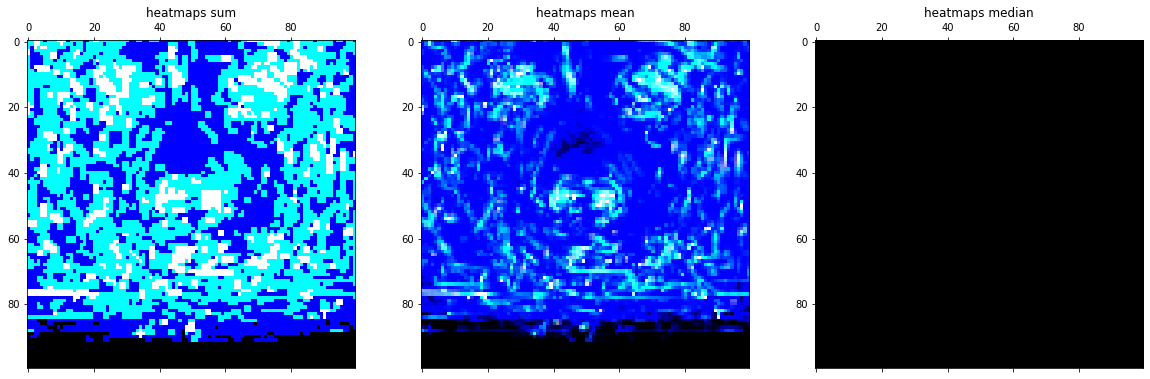

In [14]:
Adult = gradCAM(path1,'Adult')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Correct cases: 800
Total cases: 1000
Prediction accuracy: 0.8


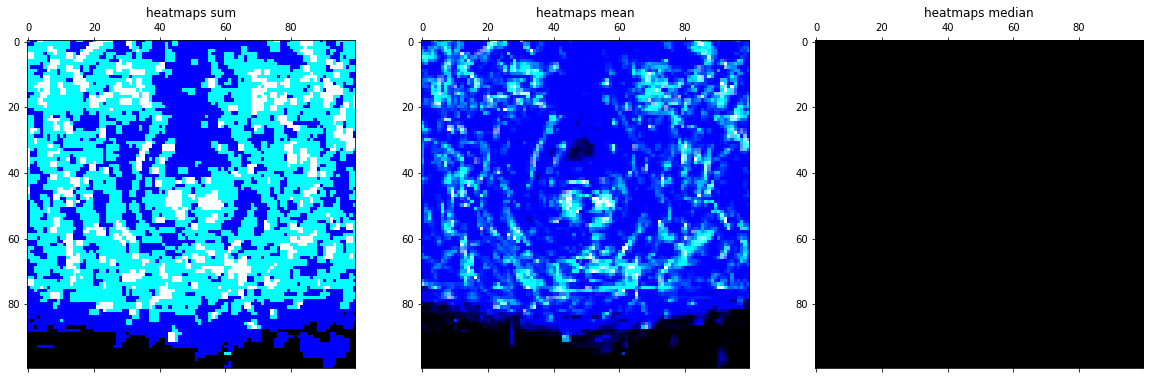

In [15]:
Young = gradCAM(path2,'Young')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Correct cases: 704
Total cases: 1000
Prediction accuracy: 0.704


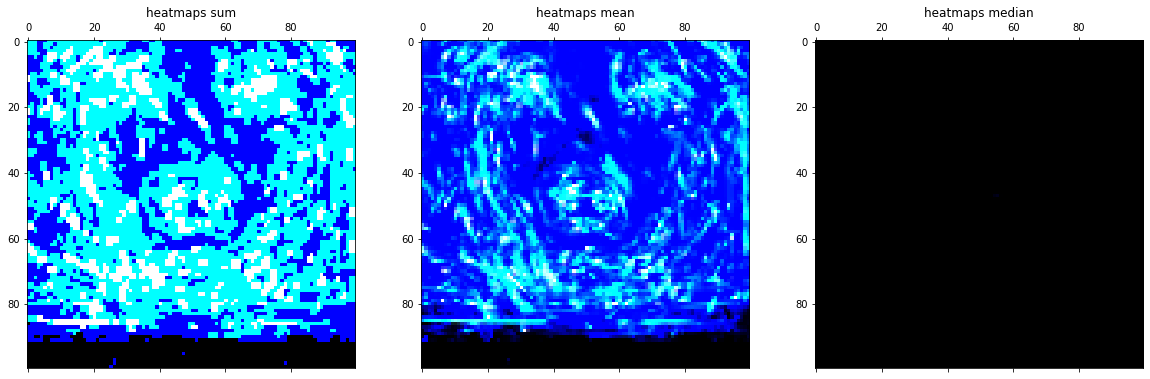

In [16]:
Senior = gradCAM(path3,'Senior')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


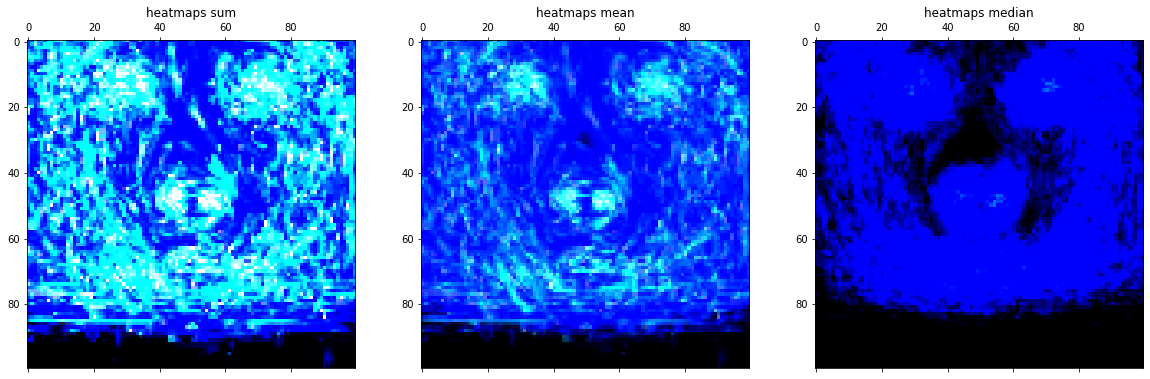

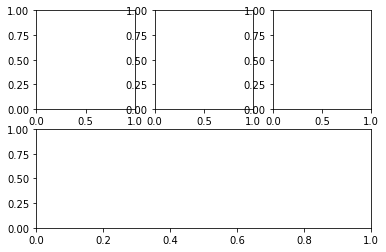

In [17]:
# Hm_sum = Adult + Young + Senior
# Hm_sum = np.array([Adult, Young, Senior])
# plt.matshow(Hm_sum)
# plt.show()
Hm_matrix = np.array([Young, Adult, Senior])
fig, ax = plt.subplots(1, 3, figsize=(20, 30))
ax[0].matshow(Hm_matrix.sum(axis=0))
ax[0].title.set_text('heatmaps sum')
ax[1].matshow(Hm_matrix.mean(axis=0))
ax[1].title.set_text('heatmaps mean')
#hm_median = np.median((hm_sum - hm_sum.min()) / (hm_sum.max() - hm_sum.min()) , axis=3)
Hm_median = np.median((Hm_matrix - Hm_matrix.mean()) / Hm_matrix.std() , axis=0)
ax[2].matshow(Hm_median)
ax[2].title.set_text('heatmaps median')
fig, ax = plt.subplots(12, 6)
ax1 = plt.subplot(2, 3, 1)
ax2 = plt.subplot(2, 3, 2)
ax3 = plt.subplot(2, 3, 3)
ax4 = plt.subplot(2, 1, 2)
# axes = [ax1, ax2, ax3, ax4]


In [28]:
def Hm_saver(heatmap,ground_truth):
    arr_reshaped = heatmap.reshape(heatmap.shape[0], -1)
    np.savetxt('/home/data/data/kodeiri/ML_project/HM/'+ ground_truth + ".txt", arr_reshaped)

In [29]:
Hm_saver(Adult,'Adult')

In [30]:
Hm_saver(Young,'Young')

In [31]:
Hm_saver(Senior,'Senior')

In [32]:
Hm_saver(Hm_median,'All_median')

In [33]:
Hm_saver(Hm_matrix.mean(axis=0),'All_mean')